In [1]:

from google.cloud import bigquery
from google.oauth2 import service_account

CREDENTIALS   = service_account.Credentials.from_service_account_file('../app/gkeys/epidemicapp-62d0d471b86f.json')

In [4]:

client = bigquery.Client(project="epidemicapp-280600", credentials=CREDENTIALS)


# Creating the states parameters table

In [22]:

sql = """
    SELECT * 
    FROM states.last_parameters
"""

pars_df = client.query(sql).to_dataframe()

In [24]:
pars_df["pop"] = 100 * pars_df["pop"]
pars_df["mu"] = 100 * pars_df["mu"]


new_cols = pars_df["state"].tolist()
pars_df = pars_df.transpose()
pars_df.columns = new_cols

In [25]:
npars_df = pars_df.iloc[:4]

npars_df.head()

,SC,RN,AM,SE,PA,RJ,MA,CE,PI,MG,...,PB,DF,PR,MT,SP,AC,PE,AL,TO,RR
Ro,14.941,7.10701,1.65325,14.8711,1.47108,1.49186,3.51755,1.55158,5.84803,2.01525,...,6.37866,1.87066,2.86233,2.98394,4.77656,2.91944,3.33237,1.91454,5.72987,5.93701
D,38.015,60,6.19799,7.24031,5.47939,5.96775,20.538,10.4223,45.9225,24.0888,...,46.7231,17.4393,33.2959,31.624,45.8576,22.013,27.6407,8.71839,5.85248,52.9515
mu,0.571131,0.3216,0.965075,1.34223,1.47269,2,0.236978,0.821211,0.245783,0.15658,...,0.192054,0.13307,0.306116,0.315887,0.439504,0.239204,0.495224,0.61271,0.96648,0.208012
pop,0.00377071,0.894182,2.56016,0.0157178,2.98103,1.65528,1.06046,3.29218,0.53722,0.485918,...,1.19883,5,5,5,0.68975,1.82812,0.462281,1.70922,0.0103129,1.74528


In [62]:

def create_table(df, n_tables=3, spaced=5):

    n_cols = df.shape[1]
    step = n_cols//n_tables
    
    ind_i, latex_table = 0, ""
    for n in range(n_tables):
        if n != n_tables-1:
            partial_table = df.iloc[:,ind_i:ind_i+step]
        else: 
            partial_table = df.iloc[:,ind_i:]

        latex_tab = partial_table.to_latex(float_format="{:0.2f}".format, column_format="c"*(partial_table.shape[1]+1))

        ind_i += step
        latex_table += latex_tab + "\n\vspace{" + str(spaced) + "mm} \n\n"
        
    return latex_table

In [63]:
latex_table = create_table(npars_df)

with open("./parameters_state_table.txt", "w") as handle:
    handle.write(latex_table)

In [159]:
npars_df.iloc[1,:].mean()

24.352511576045856

# MSE for each state

In [93]:

sql = """
    select *
    from states.last_predictions
"""
pred_df = client.query(sql).to_dataframe()


In [73]:
sql = """
    select *
    from states.real_data
"""
real_df = client.query(sql).to_dataframe()


In [74]:
pred_df.head()

,date,active_cases,recovered,deaths,state
0,2020-03-24 00:00:00+00:00,810.000000,1.000000,40.000000,SP
1,2020-03-25 00:00:00+00:00,873.145317,18.663393,43.559982,SP
2,2020-03-26 00:00:00+00:00,941.189039,37.703774,47.397490,SP
3,2020-03-27 00:00:00+00:00,1014.507226,58.227961,51.534053,SP
4,2020-03-28 00:00:00+00:00,1093.504177,80.350973,55.992852,SP


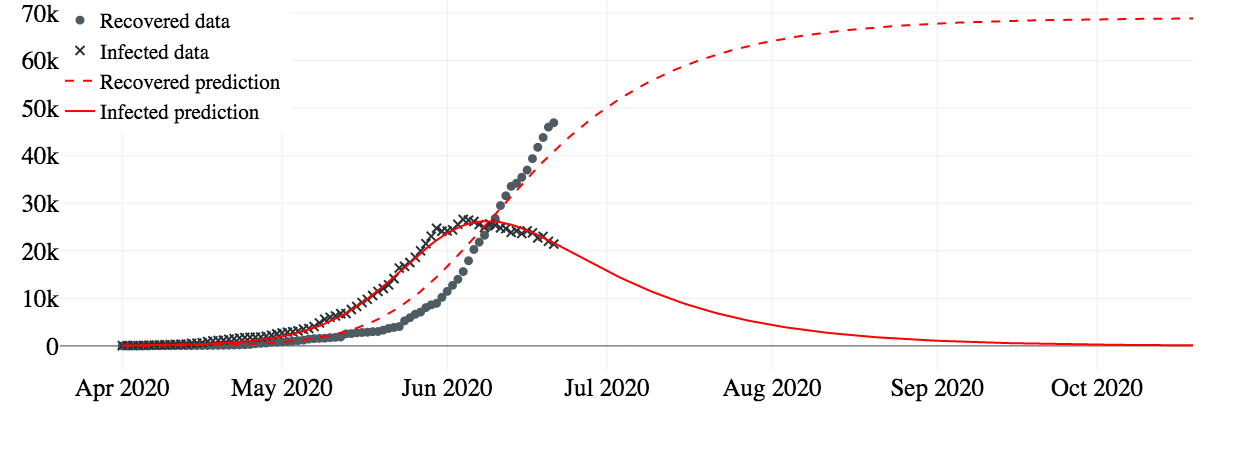

In [158]:
import plotly.graph_objects as go


state = "MA"

fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Recovered data",
    x=real_df.where(real_df["state"] == state).dropna()["date"],
    y=real_df.where(real_df["state"] == state).dropna()["recovered"],
    mode="markers",
    marker_color="#4f5b62"
))

fig.add_trace(go.Scatter(
    name="Infected data",
    x=real_df.where(real_df["state"] == state).dropna()["date"],
    y=real_df.where(real_df["state"] == state).dropna()["active_cases"],
    mode="markers",
    marker_symbol="x-thin",
    marker_line_color="#263238",
    marker_line_width=2,
))

fig.add_trace(go.Scatter(
    name="Recovered prediction",
    x=pred_df.where(pred_df["state"] == state).dropna()["date"],
    y=pred_df.where(pred_df["state"] == state).dropna()["recovered"],
    mode="lines",
    line=dict(dash="dash", width=2, color="red")
))

fig.add_trace(go.Scatter(
    name="Infected prediction",
    x=pred_df.where(pred_df["state"] == state).dropna()["date"],
    y=pred_df.where(pred_df["state"] == state).dropna()["active_cases"],
    mode="lines",
    line=dict(width=2, color="red")
))


fig.update_layout(
    autosize=False,
    template='presentation',
    font=dict(
        family="Sans Serif, bold",
        size=25,
        color="black"
    ),
    margin=dict(
        l=60,
        r=40,
        b=80,
        t=0,
        pad=0
    ),
    legend=dict(
        x=0,
        y=1,
        font=dict(
            size=21,
        ),
    )
)

fig.show(height=500, width=800)
fig.write_image("./Maranhao_Predictions.eps")

In [82]:
import pandas as pd

pred_df.columns = ["date", "pred_active_cases", "pred_recovered", "pred_deaths", "state"]

states = real_df["state"].unique().tolist()
merged_df = real_df.merge(pred_df, how="left", on=["date", "state"]).dropna()

R_squared_states = dict()

for state in states:
    state_df = merged_df.where(merged_df["state"] == state).dropna()
    
    R_squared = 0.0
    for comp in ["recovered", "active_cases", "deaths"]:
        SSE = sum( (state_df[comp] - state_df["pred_"+comp])**2 ) 
        SST = sum( (state_df[comp] - state_df[comp].mean())**2 ) 
        R_squared += 1 - (SSE / SST)
    
    R_squared_states[state] = [R_squared / 3]
R_df = pd.DataFrame(R_squared_states)    
    

In [91]:
R_df = R_df.transpose()
R_df.columns = ["R^2"]
R_df = R_df.sort_values(by="R^2", ascending=False)
R_df.head()

,R^2
AC,0.988046
BA,0.981152
MT,0.976822
MG,0.966537
AL,0.966061


In [95]:
def create_table(df, n_tables=3, spaced=5, vertical=True):
    
    if vertical:
        n_lines = df.shape[0]
        step = n_lines//n_tables
        
        ind_i, latex_table = 0, ""
        for n in range(n_tables):
            if n != n_tables-1:
                partial_table = df.iloc[ind_i:ind_i+step,:]
            else: 
                partial_table = df.iloc[ind_i:,:]

            latex_tab = partial_table.to_latex(float_format="{:0.2f}".format, column_format="c"*(partial_table.shape[1]+1))

            ind_i += step
            latex_table += latex_tab + " \hspace{" + str(spaced) + "mm} "
        
    else:
        n_cols = df.shape[1]
        step = n_cols//n_tables

        ind_i, latex_table = 0, ""
        for n in range(n_tables):
            if n != n_tables-1:
                partial_table = df.iloc[:,ind_i:ind_i+step]
            else: 
                partial_table = df.iloc[:,ind_i:]

            latex_tab = partial_table.to_latex(float_format="{:0.2f}".format, column_format="c"*(partial_table.shape[1]+1))

            ind_i += step
            latex_table += latex_tab + "\n\vspace{" + str(spaced) + "mm} \n\n"

    return latex_table


In [102]:
latex_table = create_table(R_df.transpose(), n_tables=2, vertical=False)

with open("./R_squared_state_table.txt", "w") as handle:
    handle.write(latex_table)

In [101]:
R_df.shape

(23, 1)

# Country wise results

In [184]:

sql = """
    select *
    from countries.last_predictions
    where country="BR"
"""

country_df = client.query(sql).to_dataframe()


In [185]:
country_df = country_df.groupby(by="date").mean().reset_index().sort_values(by="date")
country_df.head()

,date,I_pred,R_pred,D_pred,I,R,D
0,2020-03-29 00:00:00+00:00,4114.000000,6.000000,136.000000,4114.0,6.0,136.0
1,2020-03-30 00:00:00+00:00,4433.780628,204.214912,150.822450,4300.0,120.0,159.0
2,2020-03-31 00:00:00+00:00,4778.265614,417.837041,166.797047,5389.0,127.0,201.0
3,2020-04-01 00:00:00+00:00,5149.338883,648.056657,184.012799,6469.0,127.0,240.0
4,2020-04-02 00:00:00+00:00,5549.024053,896.154798,202.565501,7593.0,127.0,324.0


In [173]:

sql = """
    select 
      last_predictions.date as date,
      last_predictions.state as state,
      last_predictions.active_cases as pred_active_cases,
      last_predictions.recovered as pred_recovered,
      last_predictions.deaths as pred_deaths,
      real_data.active_cases as active_cases,
      real_data.recovered as recovered,
      real_data.deaths as deaths
    from states.last_predictions
      left join states.real_data 
        on real_data.date = last_predictions.date 
        and real_data.state = last_predictions.state
"""


state_grouped_df = client.query(sql).to_dataframe() #pred_df.groupby(by="date").sum().reset_index()
state_grouped_df.head()

,date,state,pred_active_cases,pred_recovered,pred_deaths,active_cases,recovered,deaths
0,2020-03-24 00:00:00+00:00,SP,810.000000,1.000000,40.000000,810.0,1.0,40.0
1,2020-03-25 00:00:00+00:00,SP,873.145317,18.663393,43.559982,854.0,1.0,48.0
2,2020-03-26 00:00:00+00:00,SP,941.189039,37.703774,47.397490,1035.0,1.0,58.0
3,2020-03-27 00:00:00+00:00,SP,1014.507226,58.227961,51.534053,1195.0,1.0,68.0
4,2020-03-28 00:00:00+00:00,SP,1093.504177,80.350973,55.992852,1362.0,1.0,84.0


In [176]:
state_grouped_df = state_grouped_df.groupby(by="date").sum().reset_index().sort_values(by="date")

In [175]:
country_df = country_df.

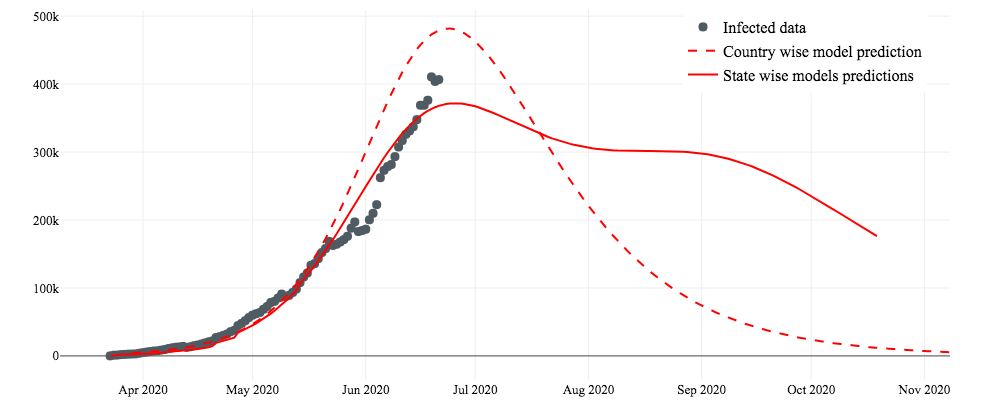

In [216]:
import plotly.graph_objects as go


fig = go.Figure()

# fig.add_trace(go.Scatter(
#     name="Infected data",
#     x=country_df["date"],
#     y=country_df["I"],
#     mode="markers",
#     marker_color="#4f5b62"
# ))

# fig.add_trace(go.Scatter(
#     name="Country wise model prediction",
#     x=country_df["date"],
#     y=country_df["I_pred"],
#     mode="lines",
#     line=dict(width=2, dash="dash", color="red")
# ))


fig.add_trace(go.Scatter(
    name="Infected data",
    x=state_grouped_df.where(state_grouped_df["active_cases"] != 0).dropna()["date"],
    y=state_grouped_df.where(state_grouped_df["active_cases"] != 0).dropna()["active_cases"],
    mode="markers",
    marker_color="#4f5b62"
))


fig.add_trace(go.Scatter(
    name="Country wise model prediction",
    x=country_df["date"],
    y=country_df["I_pred"],
    mode="lines",
    line=dict(width=2, dash="dash", color="red")
))

fig.add_trace(go.Scatter(
    name="State wise models predictions",
    x=state_grouped_df["date"],
    y=state_grouped_df["pred_active_cases"],
    mode="lines",
    line=dict(width=2, color="red")
))


fig.update_layout(
    autosize=False,
    template='presentation',
    font=dict(
        family="Sans Serif, bold",
        size=13,
        color="black"
    ),
    margin=dict(
        l=60,
        r=50,
        b=20,
        t=10,
        pad=0
    ),
    legend=dict(
        x=0.7,
        y=1,
        font=dict(
            size=16,
        ),
    )
)

fig.show(renderer="png", height=400, width=1000)
fig.write_image("./Country_State_Comparison.eps", height=400, width=1000)

In [196]:
fig.write_image("./Country_State_Comparison.eps")